In [2]:
import numpy as np
import torch as th

from Env.env import BSMarket

In [3]:
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [3]:
from Algorithms.ddpg import config

env_kwargs, model_kwargs, learn_kwargs = config.load_config('../Algorithms/learn/ddpg/tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
from pprint import pprint

pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'n_assets': 1000,
 'n_periods': 30,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [5]:
env = BSMarket(**env_kwargs)

env 'BSMarket was created!


In [6]:
def best_eval(env):
    total_pnl = 0
    obs = env.reset()
    done, info = False, {}
    while not done:
        i = env.now
        action = np.abs((env.option_prices[i+1] - env.option_prices[i])/(env.underlying_prices[i+1]-env.underlying_prices[i]))
        obs, reward, done, info = env.step(action)
        total_pnl += info['raw_reward']

    return total_pnl

In [11]:
delta_pnl = np.load('../Algorithms/learn/ddpg/best_results/ntb_pnl.npy')
rl_pnl = np.load('../Algorithms/learn/ddpg/best_results/rl_pnl.npy')
ntb_pnl = np.mean([best_eval(env) for _ in range(30)], axis=0)

AssertionError: min:0.0060987610014474345, max:10.169347414378855

In [7]:
from Utils.prices_torch import (
    geometric_brownian_motion,
    european_call_delta, european_call_price, european_option_d1
)

from Utils.tensors import set_seed

gbm_kwargs = dict(n_paths=1000,
                  n_periods=30,
                  drift=0.0,
                  volatility=0.2,
                  init_price=1.0,
                  dt=1/365)

prices = geometric_brownian_motion(**gbm_kwargs).flatten()

In [8]:
option_kwargs = dict(risk_free_interest=0.0,
                     strike = 1.0,
                     dividend = 0.0)

expiry = (gbm_kwargs['n_periods']- th.arange(len(prices)))*gbm_kwargs['dt']
volatility = th.full_like(prices, gbm_kwargs['volatility'])
options, delta = european_call_price(prices, expiry, volatility, delta_return=True)
d1 = european_option_d1(prices, expiry, volatility)

ValueError: The value argument must be within the support

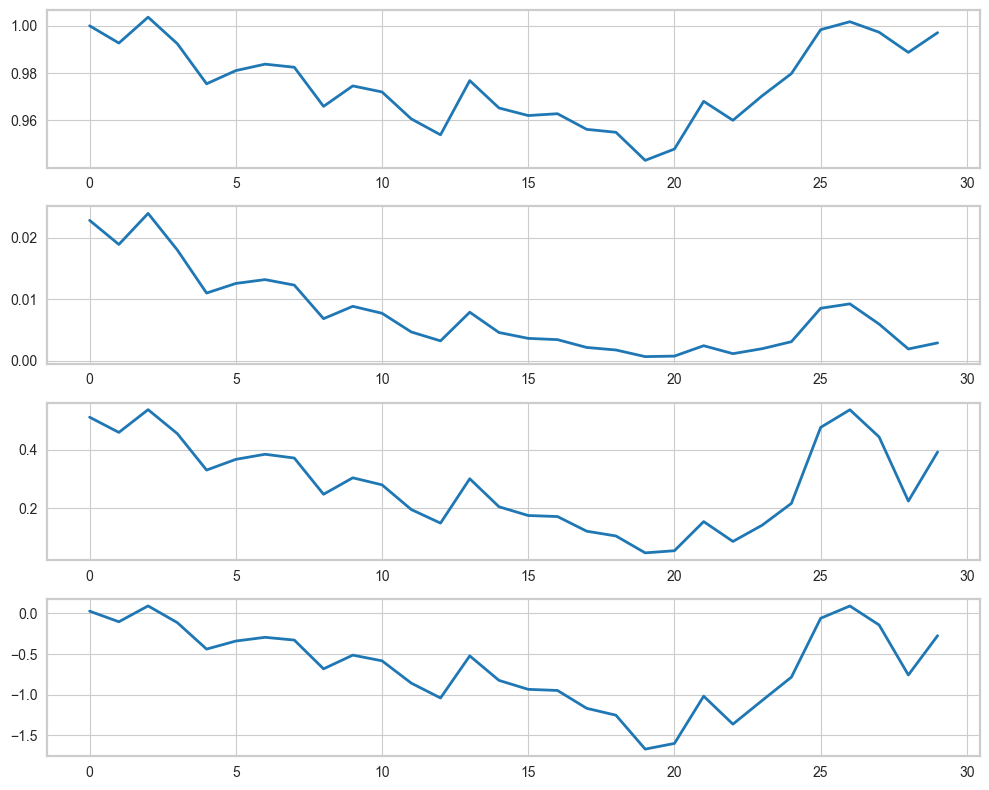

In [10]:
n = 4
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(n,1,1)
ax1.plot(prices, label='price')
ax2 = plt.subplot(n,1,2, sharex=ax1)
ax2.plot(options, label='option')
ax3 = plt.subplot(n,1,3, sharex=ax1)
ax3.plot(delta, label='delta')
ax4 = plt.subplot(n,1,4, sharex=ax1)
ax4 = plt.plot(d1, label='delta2')
plt.tight_layout()
plt.show()

In [11]:
expiry

array([0.08219178, 0.07945205, 0.07671233, 0.0739726 , 0.07123288,
       0.06849315, 0.06575342, 0.0630137 , 0.06027397, 0.05753425,
       0.05479452, 0.05205479, 0.04931507, 0.04657534, 0.04383562,
       0.04109589, 0.03835616, 0.03561644, 0.03287671, 0.03013699,
       0.02739726, 0.02465753, 0.02191781, 0.01917808, 0.01643836,
       0.01369863, 0.0109589 , 0.00821918, 0.00547945, 0.00273973])

In [20]:
(np.log(prices) + (0.5*volatility**2)*expiry+1e-6)/(volatility*np.sqrt(expiry+1e-6))

array([ 0.02868637,  0.25236382,  0.28669025,  0.29275164,  0.11037076,
        0.26605044,  0.14411093,  0.20480521,  0.10847517, -0.06646613,
        0.03329621,  0.11721377,  0.00948879,  0.40183998,  1.0520306 ,
        0.73969692,  0.55518402,  0.44007647,  0.15132806, -0.03964246,
       -0.47172942, -0.63185712, -0.63384953, -0.72673729, -0.61389145,
       -1.28286703, -1.12307085,  0.40701002, -0.25243585,  0.55618116,
       -2.72574165])

In [2]:
import numpy as np
import torch as th

from Env.env import BSMarket
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [3]:
import torch as th
from Utils.prices_torch import geometric_brownian_motion, european_call_price, european_call_delta
from Utils.tensors import set_seed

In [6]:
from easydict import EasyDict
kwargs = EasyDict(n_paths = 1000, n_periods=31,
                  drift=0.0, volatility=0.2, init_price=1.0, dt=1/365)

prices = geometric_brownian_motion(n_paths=1000, n_periods=31, drift=0.0, volatility=0.2, init_price=1.0, dt=1/365)
expiry = th.linspace((kwargs.n_periods-1)*kwargs.dt, 0, kwargs.n_periods)
expiry = th.where(expiry==0, th.tensor(1e-6), expiry)[:, None]
volatility = th.full_like(expiry, kwargs.volatility)
options, delta = european_call_price(prices, expiry, volatility, delta_return=True)

In [7]:
import torch.nn.functional as F

def get_reward(prices, options, actions, cost=0.2):
    reward = 0
    i = 0
    prev_action = 0
    info = {'option_gain': 0,
            'asset_gain': 0}

    while i < len(prices) - 1:
        option_gain = options[i]-options[i+1]
        asset_gain = - cost*prices[i]*th.abs(actions[i] - prev_action) + actions[i]*(prices[i+1]-prices[i])
        # reward += (options[i+1]-options[i]) - cost*prices[i]*(actions[i] - prev_action) + actions[i]*(prices[i+1]-prices[i])
        reward += (option_gain + asset_gain)

        info['option_gain'] += option_gain.mean()
        info['asset_gain'] += asset_gain.mean()
        prev_action = actions[i]
        i += 1

    option_gain = options[i-1] -F.relu(options[-1] - 1.0)
    asset_gain = (-cost)*prev_action*prices[i]
    # reward += -F.relu(options[-1] - options[0]) + (1-cost)*prev_action*prices[i]
    reward += (option_gain + asset_gain)

    info['option_gain'] += option_gain.mean()
    info['asset_gain'] += asset_gain.mean()
    info['raw_reward'] = reward
    return reward.mean(), info

print(get_reward(prices, options, delta, cost=0.2)[0])
print(get_reward(prices, options, delta[1:], cost=0.2)[0])

tensor(-0.5250)
tensor(-0.5054)


In [36]:
from Env.env_torch import BSMarketTorch
set_seed(65)
env = BSMarketTorch(n_assets=1000, cost=0.2, reward_fn='raw', reward_fn_kwargs={})

env 'BSMarket was created!


In [ ]:
def pnl_eval(model, env):
    pnl = 0
    set_seed(65)
    obs = env.reset()
    done, info = False, {}
    while not done:
        action = model(obs)
        obs, reward, done, info = env.step(action)
        pnl += reward

    return pnl

